# 224x224 Retina Fotoğraflarından Diyabetik Retinopati Tespiti ve Sınıflandırma projesi

# Diabetic Retinopathy Detection and Classification Project from 224x224 Retinal Photos

*İsmail DUMLU 240711003* \
*M. Mirza ERDEM 240711012* \
*M Selçuk İNCİ 240711020*

In [42]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sovitrath/diabetic-retinopathy-224x224-2019-data")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'diabetic-retinopathy-224x224-2019-data' dataset.
Path to dataset files: /kaggle/input/diabetic-retinopathy-224x224-2019-data


In [43]:
!ls -l {path}

total 56
drwxr-sr-x 7 1000 1000     0 Dec 17 13:23 colored_images
-rw-r--r-- 1 1000 1000 54948 Dec 17 13:23 train.csv


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
df = pd.read_csv("/kaggle/input/diabetic-retinopathy-224x224-2019-data/train.csv")

df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [46]:
import cv2

In [47]:
def crop_image(img,tol=7):
  if img.ndim ==2:
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]
  elif img.ndim==3:
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = gray_img>tol
    check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
    if (check_shape == 0):
      return img
    else:
      img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
      img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
      img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
      img = np.stack([img1,img2,img3],axis=-1)
    return img

def preprocess_image(image, sigmaX=10):
  image = np.array(image, dtype=np.uint8)
  image = crop_image_from_gray(image)
  image = cv2.resize(image, (224, 224))
  weighted = cv2.addweighted(image, 4, cv2.GaussianBlur(image, (0, 0), sigmaX), -4, 128)

  return weighted

In [48]:
from sklearn.model_selection import train_test_split
x = df['id_code']
y = df['diagnosis']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42, stratify=y)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [49]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [50]:
!ls -l {data_dir}

total 0
drwxr-sr-x 2 1000 1000 0 Dec 17 13:23 Mild
drwxr-sr-x 2 1000 1000 0 Dec 17 13:23 Moderate
drwxr-sr-x 2 1000 1000 0 Dec 17 13:23 No_DR
drwxr-sr-x 2 1000 1000 0 Dec 17 13:23 Proliferate_DR
drwxr-sr-x 2 1000 1000 0 Dec 17 13:23 Severe


In [51]:
diagnosis_map = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR'
}
print(diagnosis_map)

{0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferate_DR'}


In [52]:
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],

)

validation_datagen = ImageDataGenerator(
    rescale=1./255
    )


In [53]:
train_df = pd.DataFrame({'id_code': x_train, 'diagnosis': y_train})
val_df = pd.DataFrame({'id_code': x_test, 'diagnosis': y_test})

train_df['folder_name'] = train_df['diagnosis'].map(diagnosis_map)
val_df['folder_name'] = val_df['diagnosis'].map(diagnosis_map)

train_df['id_code'] = train_df['folder_name'] + '/' + train_df['id_code'] + '.png'
val_df['id_code'] = val_df['folder_name'] + '/' + val_df['id_code'] + '.png'

display(train_df.head())
display(val_df.head())

,id_code,diagnosis,folder_name
2579,No_DR/b2b79b37d314.png,0,No_DR
309,Moderate/175dd560810a.png,2,Moderate
2826,Severe/c3cd0200df79.png,3,Severe
2989,No_DR/cfed7c1172ec.png,0,No_DR
3344,Moderate/e811f39a1243.png,2,Moderate


,id_code,diagnosis,folder_name
1595,No_DR/6fe67fd7f5d1.png,0,No_DR
3449,No_DR/ef8c39eb9157.png,0,No_DR
1394,Proliferate_DR/61bbc11fe503.png,4,Proliferate_DR
1379,No_DR/60edda7b4871.png,0,No_DR
3043,No_DR/d30d079e6f9a.png,0,No_DR


In [54]:
data_dir = path + '/colored_images'
img_size = image_size[0]

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=data_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='raw'
)

validation_generator = validation_datagen.flow_from_dataframe(
    val_df,
    directory=data_dir,
    x_col='id_code',
    y_col='diagnosis',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='raw'
)

class_names = list(diagnosis_map.values())
print("Classes:", class_names)

Found 2929 validated image filenames.
Found 733 validated image filenames.
Classes: ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']


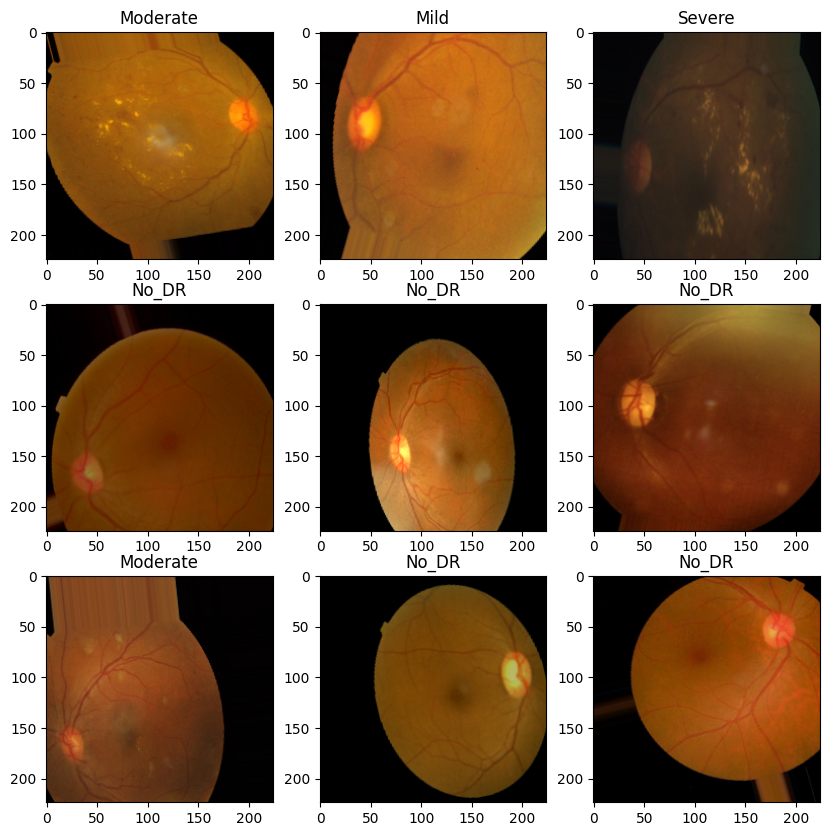

In [55]:
images, labels = next(train_generator)


plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    label_index = int(labels[i])
    plt.title(class_names[label_index])

    plt.imshow(images[i])


plt.show()

In [56]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

In [57]:
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size, img_size, 3)

)

In [58]:
base_model.trainable = True
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

In [59]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [60]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 4,336,769 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 10

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('diabetic_retinopathy_model.h5', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
